## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

In [86]:
class DetectLane:
    def __init__(self,objpoints,imgpoints):
        self.objpoints = objpoints
        self.imgpoints = imgpoints
        self.left_fit = [None]
        self.right_fit = [None]
        
    
        
    def fit_polynomial(self,binary_warped,Minv,undist):
        # Find our lane pixels first
        if self.left_fit[0] == None:
            leftx, lefty, rightx, rightx, righty = self.find_lane_pixels(binary_warped)
            

            # Fit a second order polynomial to each using `np.polyfit`
            self.left_fit = np.polyfit(lefty,leftx,2)
            self.right_fit = np.polyfit(righty, rightx, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            self.ploty = ploty
            try:
                left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
                right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx = 1*ploty**2 + 1*ploty
                right_fitx = 1*ploty**2 + 1*ploty
        else:
            left_fitx,right_fitx = self.search_around_poly(binary_warped)
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero,warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        pts= np.hstack((pts_left,pts_right))

        #Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (199,21,133))
        #Warp the blank back to original image space using inverse perspective 
        newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1],binary_warped.shape[0]))

        result = cv2.addWeighted(undist, 1, newwarp,0.3,0)


        return result
    def find_lane_pixels(self,binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis = 0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Hyperparameter
        # Choose the number of sliding windows
        nwindows = 9
        # Choose the number of sliding windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows -  based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all non zero pixel in the image 
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current position to be updated later for each window in nwindows 
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices 
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            # TO-DO: Find the four below boundaries of the window 
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            #Identify the nonzero pixels in the x ad y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            #Append these indicies to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If we found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        ## Concatenate the arrays of indicies (previously was a list of lists)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            pass

        # Extract left and right line pixel position
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, rightx, righty
    
    def process_img(self,image,type_=True):
        img = self.cal_undistort(image,self.objpoints,self.imgpoints)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        h_channel = hls[:,:,0]
        self.image_center = img.shape[1]/2

        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        thresh_min = 50 
        thresh_max = 100
         # Threshold color channel
        h_thresh_min = 100
        h_thresh_max = 255
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
#         sxbinary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 0
        mpimg.imsave("img_readme/sobel_xy_out.jpg", sxbinary, cmap='gray')

        # Threshold color channel
        s_thresh_min = 180
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        s_binary[(s_channel >= 230) & (s_channel <= 255)] = 0
        mpimg.imsave("img_readme/hsl_out.jpg", s_binary, cmap='gray')
        

        
        
        

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        
        combined_binary_c = np.copy(combined_binary)
        vertices = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
                  (0.55*img.shape[1],img.shape[0]*0.63),(0.455*img.shape[1],img.shape[0]*0.63)]],
               np.int32)
        pts = vertices.reshape((-1,1,2))
        img_c = np.copy(img)
        cv2.polylines(img_c,[pts],True,(255,0,0),3)
        mpimg.imsave("img_readme/mask_img.jpg", img_c)

        mpimg.imsave("img_readme/combined_binary.jpg", combined_binary, cmap="gray")
        
        warped,Minv = self.warp(combined_binary)
        mpimg.imsave("img_readme/warped.jpg",warped, cmap="gray")
        if type_ :
            out = self.fit_polynomial(warped,Minv,img)
#             vertices = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
#                   (0.55*img.shape[1],img.shape[0]*0.63),(0.455*img.shape[1],img.shape[0]*0.63)]],
#                np.int32)
            vertices = np.array([[(0.17*img.shape[1],img.shape[0]),(0.92*img.shape[1],img.shape[0]),
                      (0.59*img.shape[1],img.shape[0]*0.63),(0.42*img.shape[1],img.shape[0]*0.63)]],
                   np.int32)
            pts = vertices.reshape((-1,1,2))
            left_curv,right_curv = self.measure_curvature_real()
            cv2.putText(out,f"Left Curvature: {round(left_curv,3)} m",(50,100), cv2.FONT_HERSHEY_PLAIN, 2.0, (200,255,155), 2, cv2.LINE_AA)
            cv2.putText(out,f"Right Curvature: {round(right_curv,3)} m",(50,150), cv2.FONT_HERSHEY_PLAIN, 2.0, (200,255,155), 2, cv2.LINE_AA)
            left_offset = self.left_fit[0]*img.shape[0]**2 + self.left_fit[1]*img.shape[0] + self.left_fit[2]
            right_offset = self.right_fit[0]*img.shape[0]**2 + self.right_fit[1]*img.shape[0]+ self.right_fit[2]
            mid = (right_offset+left_offset)/2
            cv2.putText(out,f"Abs Offset: {round((abs(mid - self.image_center)*3.7/700),3)} m",(50,200), cv2.FONT_HERSHEY_PLAIN, 2.0, (200,255,155), 2, cv2.LINE_AA)
            lineThickness = 2
            cv2.line(out, (int(mid), 0), (int(mid), out.shape[0]), (255,0,0), lineThickness)
            cv2.line(out, (int(self.image_center), 0), (int(self.image_center), out.shape[0]), (0,0,255), lineThickness)
            binary_warped = np.dstack(( warped, warped, warped)) * 255
            height, width = out.shape[:2]

            thumbnail = cv2.resize(binary_warped, (width//4, height//4), interpolation = cv2.INTER_AREA)
            # print(thumbnail.shape,img.shape)
            out = np.array(out) 
            out[:height//4,(width-width//4):,:] = thumbnail
            cv2.polylines(out,[pts],True,(0,255,0),3);

        else:
            
            out = np.dstack(( warped, warped, warped)) * 255         
#             cv2.polylines(out,[pts],True,(255,0,0),3);
    

        return out
    def fit_poly(self,img_shape, leftx, lefty, rightx, righty):
        # To do: fit a second order polynomial to each of the line
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        self.left_fit = self.left_fit*0.4 + 0.6*left_fit
        self.right_fit = self.right_fit*0.4 + 0.6*right_fit

        # Generate x and valuse for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        # Calculate both polynomials using ploty, left_fit and right_fit
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        return left_fitx, right_fitx, ploty
    def search_around_poly(self,binary_warped):
        ## HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!

        margin = 100

        # This little tricky and useful
        # Grab activated pixel
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ## To-do: Set the area of search based on activated x-values
        ## within the +/- margin of our polynomial function
        left_lane_ids = ((nonzerox > (self.left_fit[0]*(nonzeroy**2)+ self.left_fit[1]*nonzeroy + 
                                     self.left_fit[2])-margin) & (nonzerox < (self.left_fit[0]*(nonzeroy**2)+ self.left_fit[1]*nonzeroy + 
                                     self.left_fit[2])+margin))
        right_lane_ids = ((nonzerox > (self.right_fit[0]*(nonzeroy**2)+ self.right_fit[1]*nonzeroy + 
                                     self.right_fit[2])-margin) & (nonzerox < (self.right_fit[0]*(nonzeroy**2)+ self.right_fit[1]*nonzeroy + 
                                     self.right_fit[2])+margin))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_ids]
        lefty = nonzeroy[left_lane_ids]
        rightx  = nonzerox[right_lane_ids]
        righty = nonzeroy[right_lane_ids]

        # Fit new polynomial 
        left_fitx, right_fitx, ploty = self.fit_poly(binary_warped.shape, leftx, lefty,
                                                rightx, righty)

        return left_fitx,right_fitx
    def warp(self,img):
    
        ## Define calibration box in source (original) and destination(desired or warped)
        ## coordinate

        img_size = (img.shape[1], img.shape[0])

        # Four source coordinates
#         vertices = np.array([[(0.12*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
#                           (0.55*img.shape[1],img.shape[0]*0.63),(0.43*img.shape[1],img.shape[0]*0.63)]],
#                        np.int32)
        vertices = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
                  (0.55*img.shape[1],img.shape[0]*0.63),(0.455*img.shape[1],img.shape[0]*0.63)]],
               np.int32)
        src = np.float32(vertices)

        # Four desired coordinate


        vertices = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
                          (0.87*img.shape[1],0),(0.15*img.shape[1],0)]],
                       np.int32)
        dst = np.float32(vertices)

        # Compute the perspective transforms, M
        M = cv2.getPerspectiveTransform(src,dst)

        # Could compute the inverse also by swapping the input parameters
        Minv = cv2.getPerspectiveTransform(dst,src)

        # Create warped image - usese linear interpolation
        warped = cv2.warpPerspective(img, M, img_size)

        return warped,Minv
    def cal_undistort(self,img, objpoints, imgpoints):
        undist = np.copy(img)
        gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints,\
        self.imgpoints, gray.shape[::-1],None,None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)

        return undist
    def region_of_interest(self,img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image
    
    def measure_curvature_real(self):
        '''
        Calculate the curvature of polynomial functions in meters.
        '''
        #Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700


        #Define y-value where we want radius of curvature
        #We'll choose the maximum y-value, corresponding to the bottom of the image.
        y_eval = np.max(self.ploty)

        #Claculation of R_curve (radius of curvature)
        left_curverad = ((1 + (2*self.left_fit[0]*y_eval*ym_per_pix + self.left_fit[1])**2)**1.5)/ abs(2*self.left_fit[0])
        right_curverad = ((1 + (2*self.right_fit[0]*y_eval*ym_per_pix + self.right_fit[1])**2)**1.5)/abs(2*self.right_fit[0])

        return left_curverad, right_curverad





In [3]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Part 1 of the project!!

In [87]:
import re
images = glob.glob("test_images/*")

for fname in images:
    drawLane = DetectLane(objpoints,imgpoints)
    out_img = np.copy(mpimg.imread(fname))
    out = drawLane.process_img(out_img)
    mpimg.imsave(f'output_images/{ re.findall(".*/(.*)",fname)[0]  }'   , out)

## Showing the result

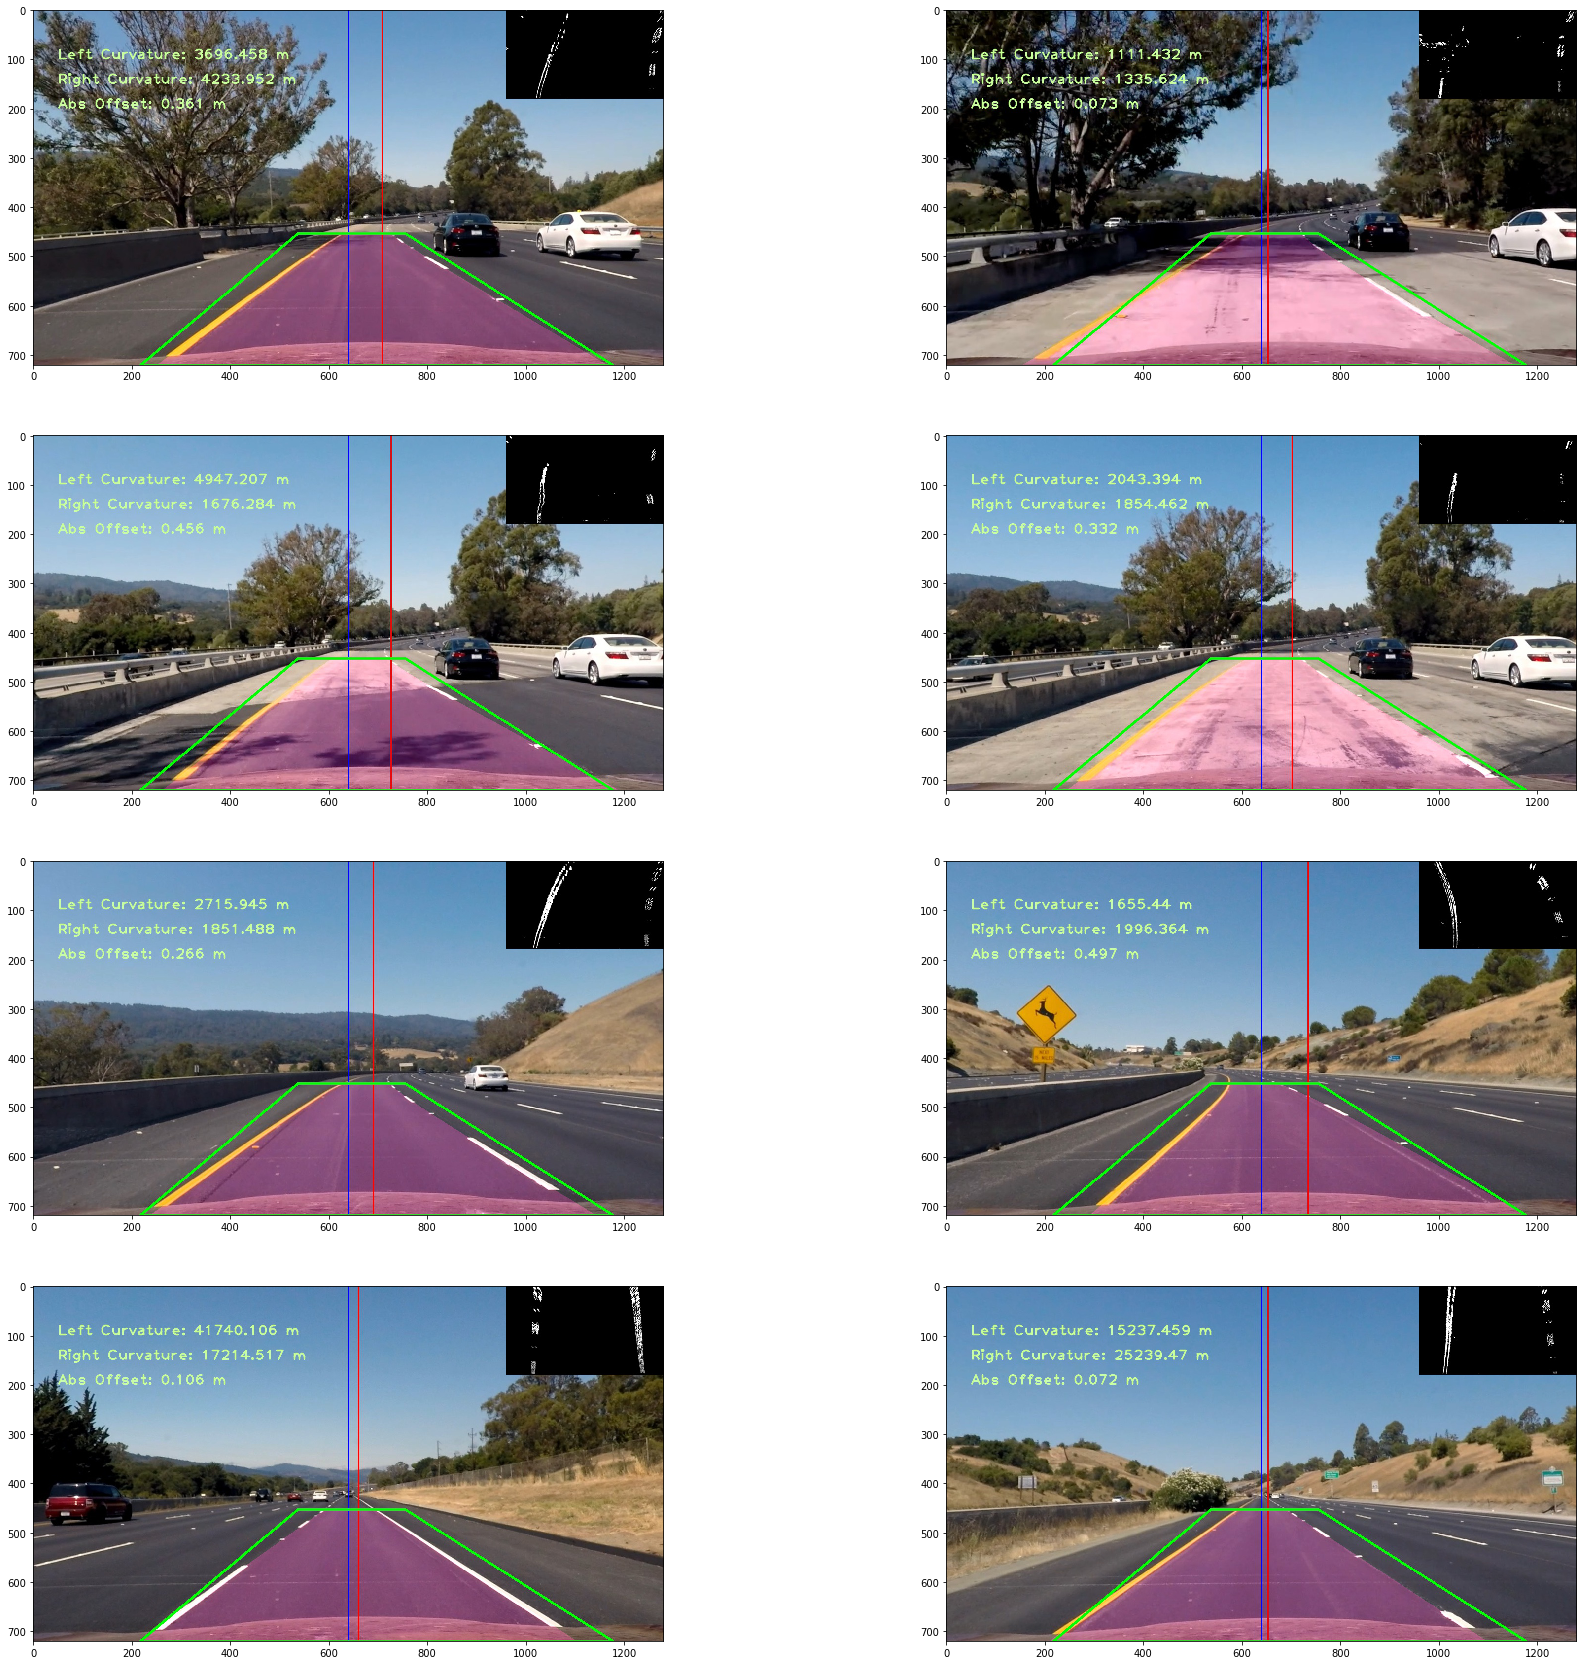

In [81]:
images = glob.glob("output_images/*.jpg")
noImage = len(images)
ncol = 2
nrow = 4
f = plt.figure(figsize=(30,30))
for index,fname in enumerate(images):
    ax = f.add_subplot(4,2,index+1)
    img = plt.imread(fname)
    ax.imshow(img)

In [82]:
drawLane = DetectLane(objpoints,imgpoints)

In [83]:
video_out = "output_video/project_video.mp4"

clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(drawLane.process_img)
%time out_clip.write_videofile(video_out, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_video/project_video.mp4.
Moviepy - Writing video output_video/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_video/project_video.mp4
CPU times: user 38min 41s, sys: 1min 53s, total: 40min 35s
Wall time: 31min 41s


In [84]:
video_out = "output_video/project_video.mp4"
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))

## Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
![Output](./img_readme/advancelaneFinder.gif)



### The Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



### Camera Calibration
In this step I calibrate the camera to remove any kind of distortion. Any real world camera has always some kind of distortion (Radial/Tangential) because camera are made up of lenses so they introduce some kind of distortion in the captured image. So with the help of openCV I correct the distortion. The common practice to correct for distortion is to take chess board images with different angles. Why chessboard images, because of high contrast between black and white boxes.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is ficed on the (x,y) plane at (z=0), such that the object points are the same for each calibration image. Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appneded with a copy f it every time I successfully detect all chessboard corners in a test image. `imgpoints` will be appended with the (x,y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:




### Pipeline (Single Images)
1. **Remove distortion from the image.**
![Alt Text](./img_readme/camera_calibration.png)
2. **Creating threshold and binary images.**
	- I used the combination of color gradient thresholds to generate a binary image in `DetectLane.process_img()` method.
	- The main idea is to use S channel with have constant value irrespective of brightness.
	- And then use algo like sobelx and sobely to recognize different gradient along different axis.
	- And then combine both of the result.
	- Here is an example of the of my output for this step.
- **HLS - saturation filtering output**
![hls_out](./img_readme/hsl_out.jpg)
- **Sobelx and Sobely gradient filtering**
![sobel_xy](./img_readme/sobel_xy_out.jpg)
- **Combined output of both**
![combined_binary](./img_readme/combined_binary.jpg)


3. **Perspective Transform**
	- In this step I change the prespective of the image so I could have a bird eye view of the lanes so I could fit a better curve through the lane lines.
	- The implementation of this step is in  `DetectLane.warp()` method.
    
    ```
    src = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
          (0.55*img.shape[1],img.shape[0]*0.63),(0.455*img.shape[1],img.shape[0]*0.63)]],
       np.int32)
       
    dst = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
                  (0.87*img.shape[1],0),(0.15*img.shape[1],0)]],
               np.int32)
    
    ```
	- Here is an example of the my output from this step.
    
 
![Color wraped](./img_readme/color_wraped.jpg)
    

4. **Fit a Curve through transformed lane line image.**
- Once we have transformed the image and have bird eye view of the lanes then we try to fit two curves for two lane lines.
- For doing this we take our two binary (with edge detetction with help of HSL channel and sobelx and sobely for detecting horizontal and vertical line respectively.
- The image is something like this.
![]()
- Then we sum all the pixels along `axis = 0` from middle of the height to the bottom of the image and by doing this we find two peaks which gives us two starting points.
- Once we find the starting point, then I decide about how many boxes or windows I will use in this image to find all the lane pixels.
- After that I divide height of image by number of boxes I will use so I got the height of box.
- And width in this project is 200 pixels.
- With the starting point I start to iterate over other boxes and I have decided on a threshold number pixels, If I get more than that number of pixels I will recalculate the mid point of the box and shift the center of the box accordingly and the threshold number in this implementation is `minpix = 100`.
- The idea is that once I do this for first frame then I will use this calculation to find all other pixel data in other frame using this same information. Like pixel data around the mid point around each box.
- Once I get all the data I fit a polynomial line through these data points with help of `np.polyfit(xlane,ylane,2)` and degree of polynomial is 2.
- And other thing which I have done in my implementation is, I have taken weighted average for lane lines weight. Something like this `newValue = newValue*0.4 + oldValue*0.6`.



